# Pilot T Data Preprocessing & Analysis

The trigger board was broken on the MEG this time around, so unfortunately we need to do a lot of corrections to compensate, which will take up a big chunk of this script. Once that's done, we can start filtering and pre-processing the data.

Define the data path and read the FIF file and stimulus PC logs for pilot subject 2. While we're at it, tag each state in the dataframe with the start trigger that should have been sent.

In [1]:
from attridict import AttriDict

RECOMPUTE_CHPI = False
RECOMPUTE_LINE_NOTCH = False
RECOMPUTE_SSS = True
RECOMPUTE_EPOCHS = True


TRIGGERS = AttriDict(
    STATEEND=10,
    TRIALEND=11,
    BLOCKEND=12,
    ITI=13,
    FIXATION=14,
    BREAK=15,
    INTERBLOCK=16,
    ABORT=17,
    ERROR=18,
    EXPEND=255,
    # 20-30 are reserved for the query condition
    QUERY=dict(
        TRUE=dict(
            F1LEFT=20,
            F1RIGHT=21,
        ),
        FALSE=dict(
            F1LEFT=22,
            F1RIGHT=23,
        ),
    ),
    # 30-40 are reserved for the two-word stimulus condition
    TWOWORD=dict(
        PHRASE=dict(
            F1LEFT=30,
            F1RIGHT=31,
        ),
        NONPHRASE=dict(
            F1LEFT=32,
            F1RIGHT=33,
        ),
        NONWORD=dict(
            F1LEFT=34,
            F1RIGHT=35,
        ),
    ),
    # 40-50 are reserved for the one-word stimulus condition
    ONEWORD=dict(
        WORD=dict(
            F1=40,
            F2=41,
        ),
        NONWORD=dict(
            F1=42,
            F2=43,
        ),
    ),
)


def nested_iteritems(d):
    for k, v in d.items():
        if isinstance(v, dict):
            for subk, v in nested_iteritems(v):
                yield (k, *subk), v
        else:
            yield (k,), v

In [2]:
import mne
import pandas as pd
import numpy as np
from autoreject import AutoReject
from pathlib import Path
from scipy.interpolate import interp1d

mne.set_config("MNE_BROWSER_BACKEND", "matplotlib")
%matplotlib inline


def get_badacq_intervals(raw):
    onsets = (raw.annotations.onset * raw.info["sfreq"] - raw.first_samp).astype(int)
    durs = (raw.annotations.duration * raw.info["sfreq"]).astype(int)
    return np.array([onsets, onsets + durs]).T


datapath = Path("/home/gercek/scratch/syntax_im/241018")
rawfile = datapath / "pilot03.fif"
raw = mne.io.read_raw_fif(rawfile, preload=True)
badacq = get_badacq_intervals(raw)
logs2w = pd.read_pickle(datapath / "2024-10-18T16_2word_experiment.pkl")
logs1w = pd.read_pickle(datapath / "2024-10-18T16_1word_experiment.pkl")
statesdf2w = logs2w["states"]
statesdf1w = logs1w["states"]
contdf2w = logs2w["continuous"]
contdf1w = logs1w["continuous"]
f1, f2 = statesdf2w["word1_freq"].unique().dropna()

statesdf2w["query_corr"] = pd.NA
for i, row in statesdf2w.iterrows():
    if i == 0:
        continue
    if row["state"] == "query":
        prevwords = statesdf2w.loc[i - 1, ["word1", "word2"]]
        statesdf2w.loc[i, "query_corr"] = np.isin(row["word1"], prevwords)


Using matplotlib as 2D backend.
Opening raw data file /home/gercek/scratch/syntax_im/241018/pilot03.fif...
    Read a total of 17 projection items:
        ssp_combined_0_68deg (1 x 306)  idle
        ssp_combined_1_68deg (1 x 306)  idle
        ssp_combined_2_68deg (1 x 306)  idle
        ssp_combined_3_68deg (1 x 306)  idle
        ssp_combined_4_68deg (1 x 306)  idle
        ssp_combined_5_68deg (1 x 306)  idle
        ssp_combined_6_68deg (1 x 306)  idle
        ssp_combined_7_68deg (1 x 306)  idle
        ssp_combined_8_68deg (1 x 306)  idle
        ssp_combined_9_68deg (1 x 306)  idle
        ssp_combined_10_68deg (1 x 306)  idle
        ssp_combined_11_68deg (1 x 306)  idle
        ssp_combined_12_68deg (1 x 306)  idle
        ssp_combined_13_68deg (1 x 306)  idle
        ssp_combined_14_68deg (1 x 306)  idle
        ssp_combined_15_68deg (1 x 306)  idle
        ssp_combined_16_68deg (1 x 306)  idle
    Range : 19000 ... 1687999 =     19.000 ...  1687.999 secs
Ready.
Opening raw

/tmp/ipykernel_1255364/3151371658.py:20: RuntimeWarning: This filename (/home/gercek/scratch/syntax_im/241018/pilot03.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(rawfile, preload=True)


Align the timestamps for the two datasets, given that clock drift is known to exist between the two sources.

Because of unreliable triggers in this recording, we need to do some dirty interpolation. There were 3 breaks in the session, during which recording was stopped. We know the trigger sent before the end of the recording to be the "break" trigger, regardless of actual value (in the case of the last break, actually the first trigger after the recording resumes because of a bug in my code).

For each of these "landmark" triggers we also know when the stimulus PC _thinks_ it sent the trigger. Because we know both timestamps reliably we can then do linear interpolation between landmarks to get the mapping of _stimulus PC log times_ to _acquisition PC time_. This interpolation should account for most of the clock drift, which we pray is linear (we'll check this through the slopes of the interpolants)

In [3]:
def map_trigger(row, f1, f2):
    condmap = {
        "2w": {
            "phrase": "PHRASE",
            "non-phrase": "NONPHRASE",
            "non-word": "NONWORD",
        },
        "1w": {
            "word": "WORD",
            "non-word": "NONWORD",
        },
        "f": {
            "1w": {
                f1: "F1",
                f2: "F2",
            },
            "2w": {
                f1: "F1LEFT",
                f2: "F1RIGHT",
            },
        },
        "other": {
            "intertrial": "ITI",
            "fixation": "FIXATION",
            "query": "QUERY",
            "pause": "BREAK",
        },
    }
    match (row.state, row.condition, row.word1_freq):
        case ("words", cond, w1f):
            st_trigs = TRIGGERS["TWOWORD"]
            k1, k2 = condmap["2w"][cond], condmap["f"]["2w"][w1f]
            return st_trigs[k1][k2]
        case ("word", cond, w1f):
            st_trigs = TRIGGERS["ONEWORD"]
            k1, k2 = condmap["1w"][cond], condmap["f"]["1w"][w1f]
            return st_trigs[k1][k2]
        case ("query", _, w1f):
            st_trigs = TRIGGERS["QUERY"]
            k1, k2 = str(row.query_corr).upper(), "F1LEFT"
            return st_trigs[k1][k2]
        case _:
            return TRIGGERS[condmap["other"][row.state]]


flattrigs = {v: k for k, v in nested_iteritems(TRIGGERS)}
bintrigs = np.unpackbits(np.array(list(flattrigs.keys()), dtype=np.uint8).reshape(-1, 1), axis=1)

triggers = mne.find_events(
    raw, stim_channel="STI102", shortest_event=1, output="offset", consecutive=False
)
endtrig_mask = triggers[:, 2] <= 14
endtrig_t = triggers[endtrig_mask][:, 0]
othertrigs = triggers[~endtrig_mask]

# Get the break times for the 3 subject breaks from the triggers. The final 2 are noise, not breaks.
# Also get the first trigger from the 2-word experiment, which is the end of the first fixation
breaktrigs2w = othertrigs[othertrigs[:, 2] == 15][:3, 0]
firsttrig = endtrig_t[0]
lasttrig2w = triggers[np.searchsorted(triggers[:, 0], breaktrigs2w[-1]) - 1, 0]
# For the 1-word experiment we need to use the first state's start trigger. The log of the initial
# pause state is not saved, as it is overwritten by the first word state.
datastart1w = (raw.annotations.onset[-1] + raw.annotations.duration[-1]) * raw.info["sfreq"]
firstwordtrig1w = othertrigs[np.searchsorted(othertrigs[:, 0], datastart1w), 0]
lasttrig1w = triggers[-1, 0]
aligntrigs = np.hstack([firsttrig, breaktrigs2w[:-1], lasttrig2w, firstwordtrig1w, lasttrig1w])

# Get the corresponding times from the experiment log for those triggers
endfirst2w = statesdf2w.loc[0]["state_end"]
aligntimes2w = statesdf2w.query("state == 'pause'")["state_start"].values
endtime2w = statesdf2w.iloc[-1]["state_end"]
aligntime1w = statesdf1w.loc[1]["state_start"]
endtime1w = statesdf1w.iloc[-1]["state_end"]
aligntimes = np.hstack([endfirst2w, aligntimes2w, endtime2w, aligntime1w, endtime1w])

# Create intervals on which to generate interpolators, and remove the one that links the end of
# the 2-word experiment to the start of the 1-word experiment
trigints = np.lib.stride_tricks.sliding_window_view(aligntrigs, 2)
trigints = np.vstack((trigints[:3], trigints[-1]))  # Pop out the 4th interval
logints = np.lib.stride_tricks.sliding_window_view(aligntimes, 2)
logints = np.vstack((logints[:3], logints[-1]))  # Pop out the 4th interval

interpolators = {
    i: interp1d(x, y, fill_value="extrapolate") for i, (x, y) in enumerate(zip(logints, trigints))
}


# Interpolate the triggers for the 1-word experiment, and create an events array from those
events2w = np.zeros((len(statesdf2w) * 2, 3), dtype=int)
for i, row in enumerate(statesdf2w.itertuples()):
    start, end = row.state_start, row.state_end
    binidx = np.digitize(end, aligntimes[:4], right=True) - 1
    binidx = 0 if binidx < 0 else binidx
    interp = interpolators[binidx]
    events2w[i * 2] = [int(interp(start)), 0, map_trigger(row, f1, f2)]
    events2w[i * 2 + 1] = [int(interp(end)), 0, 10]

events1w = np.zeros((len(statesdf1w) * 2, 3), dtype=int)
for i, row in enumerate(statesdf1w.itertuples()):
    start, end = row.state_start, row.state_end
    interp = interpolators[3]
    events1w[i * 2] = [int(interp(start)), 0, map_trigger(row, f1, f2)]
    events1w[i * 2 + 1] = [int(interp(end)), 0, 10]

cleanevents = np.vstack([events2w, events1w])
mne.write_events(rawfile.with_name("pilot03-eve.fif"), cleanevents, overwrite=True)

2590 events found on stim channel STI102
Event IDs: [ 8 10 11 14 15 30 31 32 33 34 35 38 39 40 41 42 43 46 47 56 59 62 63]
Overwriting existing file.


First let's look at the raw power spectrum and see if anything badly needs correcting:

Setting 140000 of 2656000 (5.27%) samples to NaN, retaining 2516000 (94.73%) samples.


Effective window size : 2.048 (s)
Data split into 4 (probably unequal) chunks due to "bad_*" annotations. Parallelization may be sub-optimal.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 120 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:   12.3s remaining:   12.3s


Plotting power spectral density (dB=True).


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   14.7s finished


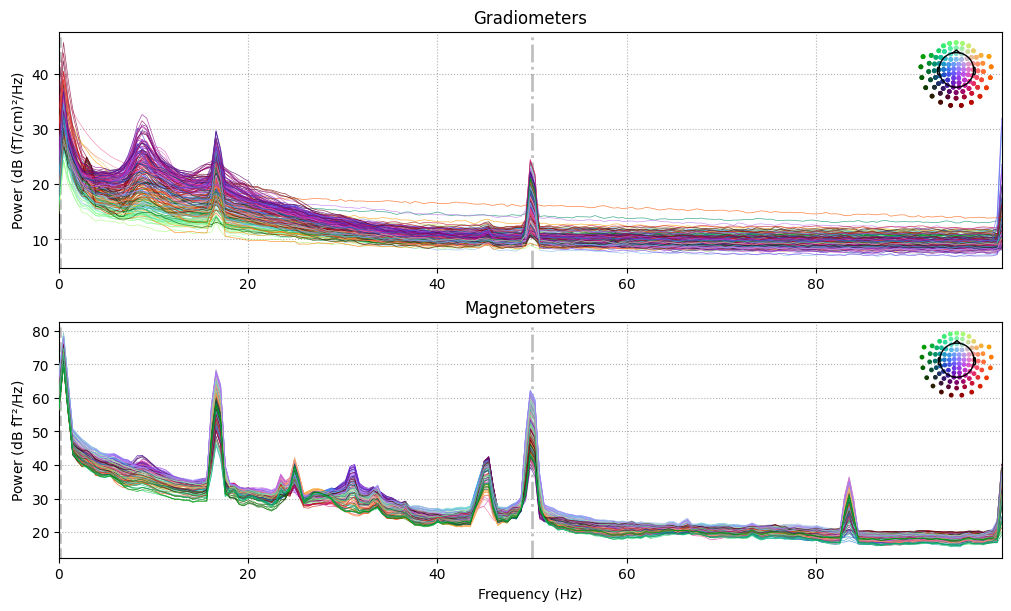

In [4]:
fig = raw.compute_psd(fmax=100, n_jobs=-1).plot(picks="meg", exclude="bads", amplitude=False)

Let's now filter out the cHPI indicator from the data and perform maxwell filtering.

In [5]:
if RECOMPUTE_CHPI:
    chpi_amplitudes = mne.chpi.compute_chpi_amplitudes(raw)
    chpi_locs = mne.chpi.compute_chpi_locs(raw.info, chpi_amplitudes)
    head_po = mne.chpi.compute_head_pos(raw.info, chpi_locs, verbose=True)
    mne.chpi.write_head_pos(rawfile.with_name("pilot03-head.pos"), head_po)
    raw.plot(picks="meg", start=100.0, duration=60.0)
    preproc = mne.chpi.filter_chpi(
        raw,
        include_line=False,
        t_step=0.01,
        t_window="auto",
        ext_order=1,
        allow_line_only=False,
        verbose=None,
    )
    preproc.plot(picks="meg", start=100.0, duration=60.0)
    preproc.save(rawfile.with_name("pilot03-cHPI-preproc.fif"), overwrite=True)
else:
    preproc = mne.io.read_raw_fif(rawfile.with_name("pilot03-cHPI-preproc.fif"), preload=True)
    head_po = mne.chpi.read_head_pos(rawfile.with_name("pilot03-head.pos"))

Opening raw data file /home/gercek/scratch/syntax_im/241018/pilot03-cHPI-preproc.fif...


/tmp/ipykernel_1255364/2606009259.py:19: RuntimeWarning: This filename (/home/gercek/scratch/syntax_im/241018/pilot03-cHPI-preproc.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  preproc = mne.io.read_raw_fif(rawfile.with_name("pilot03-cHPI-preproc.fif"), preload=True)


    Read a total of 17 projection items:
        ssp_combined_0_68deg (1 x 306)  idle
        ssp_combined_1_68deg (1 x 306)  idle
        ssp_combined_2_68deg (1 x 306)  idle
        ssp_combined_3_68deg (1 x 306)  idle
        ssp_combined_4_68deg (1 x 306)  idle
        ssp_combined_5_68deg (1 x 306)  idle
        ssp_combined_6_68deg (1 x 306)  idle
        ssp_combined_7_68deg (1 x 306)  idle
        ssp_combined_8_68deg (1 x 306)  idle
        ssp_combined_9_68deg (1 x 306)  idle
        ssp_combined_10_68deg (1 x 306)  idle
        ssp_combined_11_68deg (1 x 306)  idle
        ssp_combined_12_68deg (1 x 306)  idle
        ssp_combined_13_68deg (1 x 306)  idle
        ssp_combined_14_68deg (1 x 306)  idle
        ssp_combined_15_68deg (1 x 306)  idle
        ssp_combined_16_68deg (1 x 306)  idle
    Range : 19000 ... 1797999 =     19.000 ...  1797.999 secs
Ready.
Opening raw data file /home/gercek/scratch/syntax_im/241018/pilot03-cHPI-preproc-1.fif...
    Read a total of 17 proje

Setting 140000 of 2656000 (5.27%) samples to NaN, retaining 2516000 (94.73%) samples.
Effective window size : 2.048 (s)
Data split into 4 (probably unequal) chunks due to "bad_*" annotations. Parallelization may be sub-optimal.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 120 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    9.8s remaining:    9.8s


Plotting power spectral density (dB=True).


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   11.6s finished


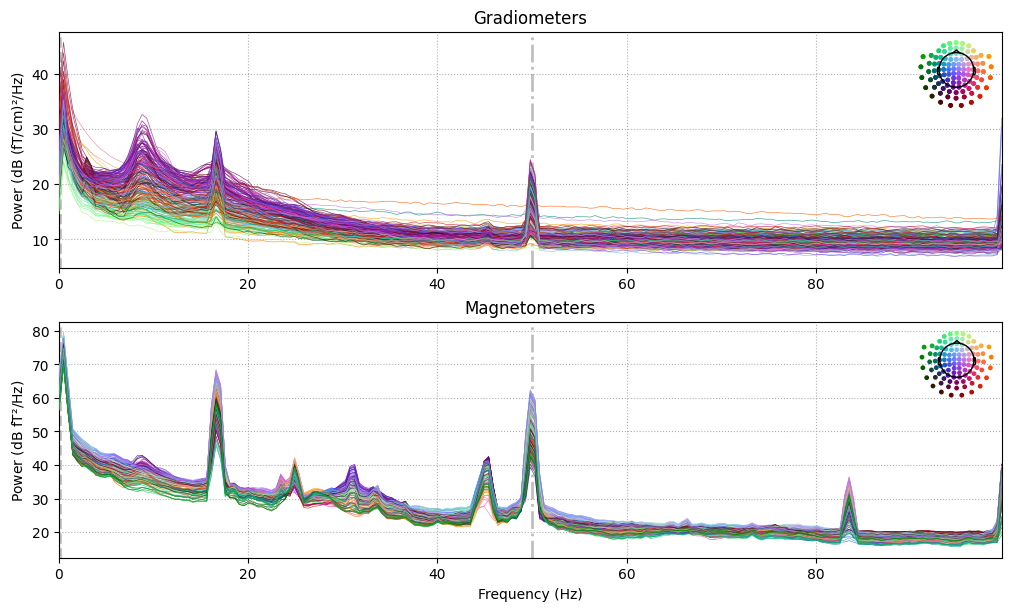

In [6]:
fig = preproc.compute_psd(fmax=100, n_jobs=-1).plot()

In [7]:
if RECOMPUTE_LINE_NOTCH:
    freqs = np.arange(1, 5) * 50  # First 4 harmonics of 50 Hz
    freqs = np.concatenate(
        [freqs, np.arange(1, 4) * (50 / 3)]
    )  # Also filter the 3-phase train noise
    preproc = preproc.filter(l_freq=0.1, h_freq=40, picks="data", n_jobs="cuda")
    preproc = preproc.notch_filter(freqs, picks="data", n_jobs=-1, filter_length="10s")
    preproc.save(rawfile.with_name("pilot03-cHPI-line-notch-preproc.fif"), overwrite=True)
    empty_room = mne.io.read_raw_fif(datapath / "ER.fif", preload=True)
    er_filt = empty_room.filter(l_freq=0.1, h_freq=40, picks="data", n_jobs="cuda")
    er_filt = er_filt.notch_filter(freqs, picks="data", n_jobs=-1, filter_length="10s")
    er_filt.save(datapath / "ER-line-notch-preproc.fif", overwrite=True)
else:
    preproc = mne.io.read_raw_fif(
        rawfile.with_name("pilot03-cHPI-line-notch-preproc.fif"), preload=True
    )
    er_filt = mne.io.read_raw_fif(datapath / "ER-line-notch-preproc.fif", preload=True)


Opening raw data file /home/gercek/scratch/syntax_im/241018/pilot03-cHPI-line-notch-preproc.fif...


/tmp/ipykernel_1255364/1292545360.py:14: RuntimeWarning: This filename (/home/gercek/scratch/syntax_im/241018/pilot03-cHPI-line-notch-preproc.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  preproc = mne.io.read_raw_fif(


    Read a total of 17 projection items:
        ssp_combined_0_68deg (1 x 306)  idle
        ssp_combined_1_68deg (1 x 306)  idle
        ssp_combined_2_68deg (1 x 306)  idle
        ssp_combined_3_68deg (1 x 306)  idle
        ssp_combined_4_68deg (1 x 306)  idle
        ssp_combined_5_68deg (1 x 306)  idle
        ssp_combined_6_68deg (1 x 306)  idle
        ssp_combined_7_68deg (1 x 306)  idle
        ssp_combined_8_68deg (1 x 306)  idle
        ssp_combined_9_68deg (1 x 306)  idle
        ssp_combined_10_68deg (1 x 306)  idle
        ssp_combined_11_68deg (1 x 306)  idle
        ssp_combined_12_68deg (1 x 306)  idle
        ssp_combined_13_68deg (1 x 306)  idle
        ssp_combined_14_68deg (1 x 306)  idle
        ssp_combined_15_68deg (1 x 306)  idle
        ssp_combined_16_68deg (1 x 306)  idle
    Range : 19000 ... 1797999 =     19.000 ...  1797.999 secs
Ready.
Opening raw data file /home/gercek/scratch/syntax_im/241018/pilot03-cHPI-line-notch-preproc-1.fif...
    Read a total 

/tmp/ipykernel_1255364/1292545360.py:17: RuntimeWarning: This filename (/home/gercek/scratch/syntax_im/241018/ER-line-notch-preproc.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  er_filt = mne.io.read_raw_fif(datapath / "ER-line-notch-preproc.fif", preload=True)


Setting 140000 of 2656000 (5.27%) samples to NaN, retaining 2516000 (94.73%) samples.
Effective window size : 2.048 (s)
Data split into 4 (probably unequal) chunks due to "bad_*" annotations. Parallelization may be sub-optimal.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 120 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    9.2s remaining:    9.2s


Plotting power spectral density (dB=True).


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   11.3s finished


Effective window size : 2.048 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 120 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of 128 | elapsed:    0.6s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  61 out of 128 | elapsed:    0.7s remaining:    0.8s


Plotting power spectral density (dB=True).


[Parallel(n_jobs=-1)]: Done  87 out of 128 | elapsed:    0.8s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 113 out of 128 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    1.0s finished


Text(0.5, 0.98, 'ER Notch filtered')

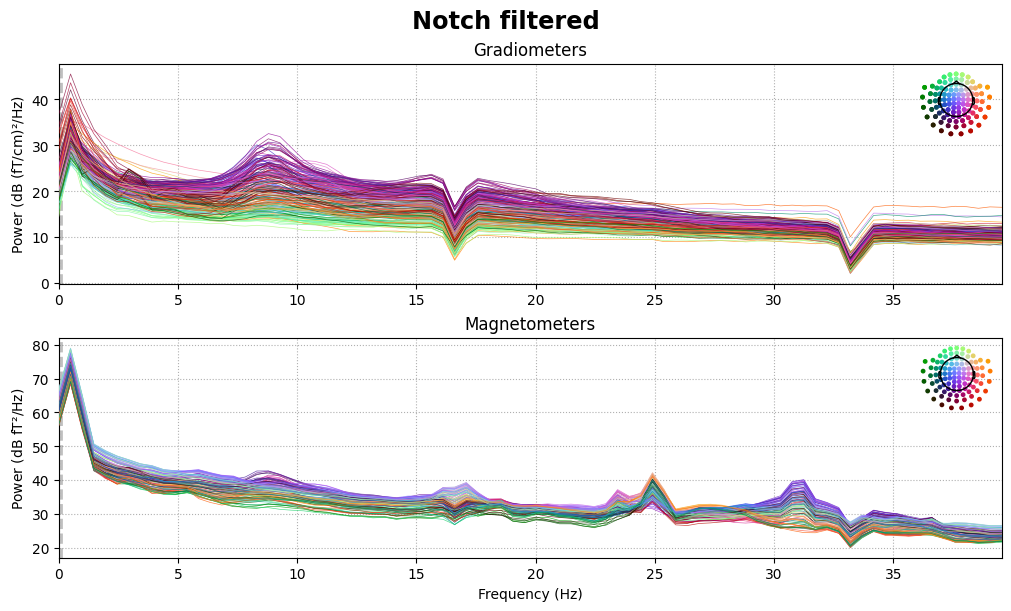

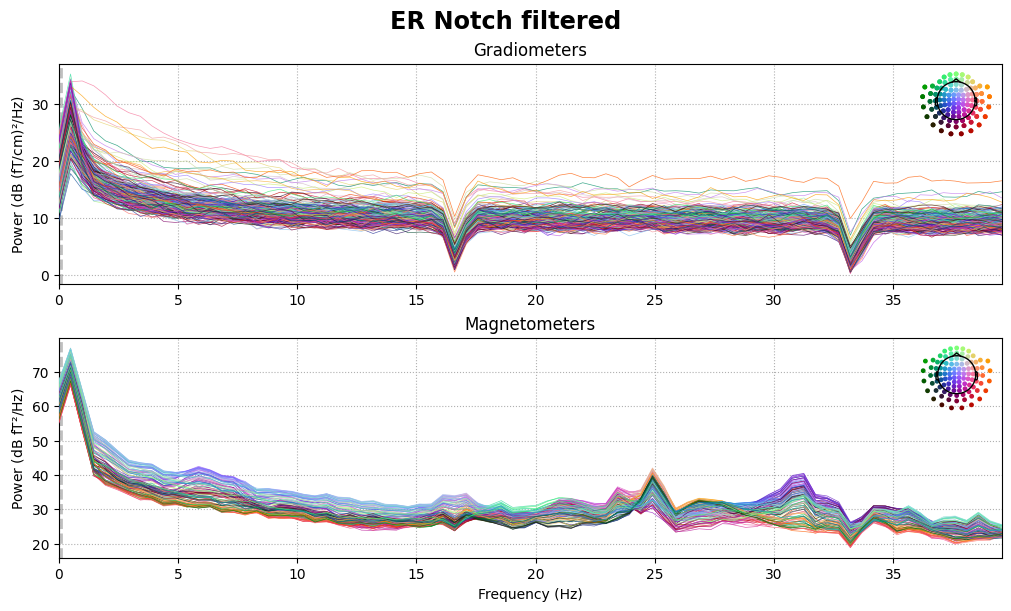

In [8]:
fig = preproc.compute_psd(fmax=40, n_jobs=-1).plot(picks="data", exclude="bads")
fig.suptitle("Notch filtered", size="xx-large", weight="bold")
fig = er_filt.compute_psd(fmax=40, n_jobs=-1).plot(picks="data", exclude="bads")
fig.suptitle("ER Notch filtered", size="xx-large", weight="bold")

In [9]:
cal_file = datapath.parent / "sss_cal.dat"
ct_file = datapath.parent / "ct_sparse.fif"

if RECOMPUTE_SSS:
    preproc_check = preproc.copy()
    auto_noisy_chs, auto_flat_chs, autoscores = mne.preprocessing.find_bad_channels_maxwell(
        preproc_check,
        cross_talk=ct_file,
        calibration=cal_file,
        return_scores=True,
        verbose=True,
    )
    er_filt_check = er_filt.copy()
    er_filt_check = mne.preprocessing.maxwell_filter_prepare_emptyroom(
        raw_er=er_filt_check, raw=preproc_check
    )
    auto_noisy_chs_er, auto_flat_chs_er, autoscores_er = (
        mne.preprocessing.find_bad_channels_maxwell(
            er_filt_check,
            cross_talk=ct_file,
            calibration=cal_file,
            return_scores=True,
            verbose=True,
        )
    )


The input data has already been low-pass filtered with a 40.0 Hz cutoff frequency, which is equal to the requested cutoff of 40.0 Hz. Not applying low-pass filter.
Scanning for bad channels in 502 intervals (5.0 s) ...
    No bad MEG channels
    Processing 204 gradiometers and 102 magnetometers
    Using fine calibration sss_cal.dat
        Adjusting non-orthogonal EX and EY
        Adjusted coil positions by (μ ± σ): 0.4° ± 0.4° (max: 2.0°)
    Automatic origin fit: head of radius 82.5 mm
    Using origin -0.2, 3.9, 46.6 mm in the head frame
        Interval   1:    0.000 -    4.999
        Interval   2:    5.000 -    9.999
        Interval   3:   10.000 -   14.999
        Interval   4:   15.000 -   19.999
        Interval   5:   20.000 -   24.999
        Interval   6:   25.000 -   29.999
        Interval   7:   30.000 -   34.999
        Interval   8:   35.000 -   39.999
        Interval   9:   40.000 -   44.999
        Interval  10:   45.000 -   49.999
        Interval  11:   50.000

NameError: name 'empty_room' is not defined

In [11]:
if RECOMPUTE_SSS:
    print(auto_noisy_chs, auto_flat_chs_er)  # we should find them!
    print(auto_flat_chs, auto_flat_chs_er)  # none for this dataset
    print(raw.info["bads"], er_filt_check.info["bads"])  # none for this dataset
    # %% remove bad channel, bad projector, then SSS
    bads = list(set(auto_noisy_chs + auto_flat_chs + auto_flat_chs_er + auto_noisy_chs_er))
    preproc_check.info["bads"] += bads
    er_filt_check.info["bads"] += bads


['MEG0213', 'MEG1011', 'MEG1031', 'MEG1242', 'MEG1911', 'MEG1932', 'MEG2122', 'MEG2332', 'MEG2512'] []
[] []
[] []


In [12]:
del preproc
if RECOMPUTE_SSS:
    preproc_sss = mne.preprocessing.maxwell_filter(
        preproc_check,
        cross_talk=ct_file,
        calibration=cal_file,
        head_pos=head_po,
        st_duration=20.0,
        verbose=True,
    )
    er_filt_sss = mne.preprocessing.maxwell_filter(
        er_filt_check,
        cross_talk=ct_file,
        calibration=cal_file,
        head_pos=head_po,
        st_duration=20.0,
        verbose=True,
    )
    preproc_sss.save(rawfile.with_name("pilot03-cHPI-line-sss-preproc.fif"), overwrite=True)
    er_filt_sss.save(datapath / "ER-line-sss-preproc.fif", overwrite=True)
else:
    preproc_sss = mne.io.read_raw_fif(
        rawfile.with_name("pilot03-cHPI-line-sss-preproc.fif"), preload=True
    )

Maxwell filtering raw data


    Bad MEG channels being reconstructed: ['MEG1932', 'MEG2512', 'MEG2332', 'MEG1242', 'MEG1011', 'MEG0213', 'MEG1911', 'MEG1031', 'MEG2122']
    Processing 204 gradiometers and 102 magnetometers
    Using fine calibration sss_cal.dat
        Adjusting non-orthogonal EX and EY
        Adjusted coil positions by (μ ± σ): 0.4° ± 0.4° (max: 2.0°)
    Automatic origin fit: head of radius 82.5 mm
    Using origin -0.2, 3.9, 46.6 mm in the head frame
    Processing data using tSSS with st_duration=20.0
        Using 90/95 harmonic components for    0.000  (75/80 in, 15/15 out)
    Appending head position result channels and copying original raw data
    Spatiotemporal window did not fit evenly intocontiguous data segment. 13.00 seconds were lumped into the previous window.
    Spatiotemporal window did not fit evenly intocontiguous data segment. 3.00 seconds were lumped into the previous window.
    Processing 125 data chunks
        Using 90/95 harmonic components for    0.000  (75/80 in, 1

/tmp/ipykernel_1255364/3397793367.py:19: RuntimeWarning: This filename (/home/gercek/scratch/syntax_im/241018/pilot03-cHPI-line-sss-preproc.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  preproc_sss.save(rawfile.with_name("pilot03-cHPI-line-sss-preproc.fif"), overwrite=True)


Closing /home/gercek/scratch/syntax_im/241018/pilot03-cHPI-line-sss-preproc.fif
Overwriting existing file.
Writing /home/gercek/scratch/syntax_im/241018/pilot03-cHPI-line-sss-preproc-1.fif
Closing /home/gercek/scratch/syntax_im/241018/pilot03-cHPI-line-sss-preproc-1.fif
[done]
Writing /home/gercek/scratch/syntax_im/241018/ER-line-sss-preproc.fif


/tmp/ipykernel_1255364/3397793367.py:20: RuntimeWarning: This filename (/home/gercek/scratch/syntax_im/241018/ER-line-sss-preproc.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  er_filt_sss.save(datapath / "ER-line-sss-preproc.fif", overwrite=True)


Closing /home/gercek/scratch/syntax_im/241018/ER-line-sss-preproc.fif
[done]


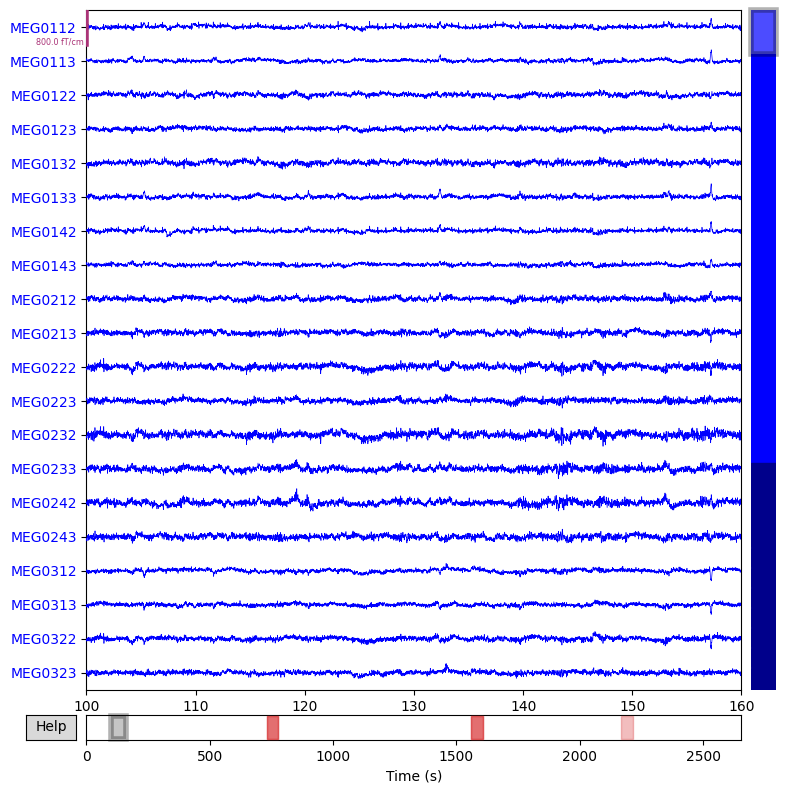

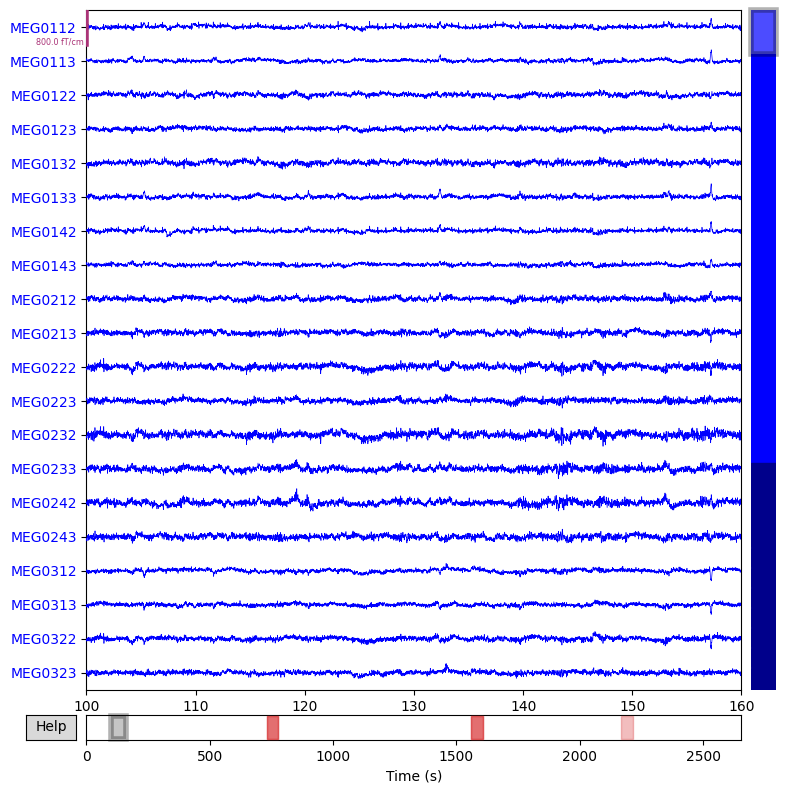

In [13]:
preproc_sss.plot(picks="meg", start=100.0, duration=60.0)


Finally, now that we've filtered and cleaned a bit on our data, let's create epochs and save the data. Beyond this we should use a new notebook, as this one is getting painfully long and already has use an embarrasing amount of memory. The final file is around 12 GB (!!!)

In [27]:
if RECOMPUTE_EPOCHS:
    events1w = cleanevents[np.isin(cleanevents[:, 2], np.arange(40, 50))]
    events2w = cleanevents[np.isin(cleanevents[:, 2], np.arange(30, 40))]
    for tag, events in {"2w": events2w, "1w": events1w}.items():
        usedtrigs = np.unique(events[:, 2])
        triglabels = {"/".join(k): v for k, v in nested_iteritems(TRIGGERS) if v in usedtrigs}
        epochs = mne.Epochs(
            preproc_sss, events, event_id=triglabels, tmin=-0.2, tmax=2.0, preload=True
        )
        epochs.save(datapath / f"pilot03-preproc-{tag}-epo.fif", overwrite=True)


Not setting metadata
540 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 540 events and 2201 original time points ...
1 bad epochs dropped
Not setting metadata
120 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 120 events and 2201 original time points ...
0 bad epochs dropped


In [ ]:
epochpath1w = mne.read_epochs(datapath / "pilot03-preproc-1w-epo.fif")
epochpath2w = mne.read_epochs(datapath / "pilot03-preproc-2w-epo.fif")
epochs1w = AutoReject(n_jobs=-1, picks="meg").fit_transform(epochpath1w)
epochs1w.save(datapath / "pilot03-preproc-1w-epo-autorej.fif")
del epochs1w
epochs2w = AutoReject(n_jobs=-1, picks="meg").fit_transform(epochpath2w)
epochs2w.save(datapath / "pilot03-preproc-2w-epo-autorej.fif")